# Identifying Consumer Demographic Groups Using Convolutional Neural Networks
by Kevin Atkinson

## Business Understanding
Two of the major factors in advertising products to consumers are age and gender. While there are many factors in ascertaining the most optimal product advertisements to serve to an individual, these two to encompass a large portion of the equation. In this project we will attempt to use images of individuals to classify their age and gender to better target ads to individuals. 

One such application for this technology would be a cosmetics retail store such as an Ulta or Sephora. Using in-store cameras to identify the demographics of individual customers and display targeted advertisements locally.


## Data Understanding

Our data is being sourced from the [B3FD](https://github.com/kbesenic/B3FD) dataset. We will be using subsets that have the classification targets of Age and Gender

In [51]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
import visualkeras
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [5]:
imdb = pd.read_csv('B3FD_metadata/B3FD-IMDB_age_gender.csv', delimiter=' ')
wiki = pd.read_csv('B3FD_metadata/B3FD-WIKI_age_gender.csv', delimiter=' ')

In [6]:
len(imdb), len(wiki)

(204514, 40690)

In [7]:
df = pd.concat([imdb, wiki])
df = df.reset_index(drop=True)
df.tail()

,path,age,gender
245199,mariajookoehler/22656187_1992-10-08_2015.jpg,23,F
245200,willdemps/1805168_1979-11-07_2007.jpg,28,M
245201,pierreallen/32740287_1987-11-18_2012.jpg,25,M
245202,patdecola/30326918_1987-06-30_2011.jpg,24,M
245203,ullazirne/42028665_1995-08-06_2012.jpg,17,F


In [8]:
len(df)

245204

In [9]:
# Checking to see if we have any null values
df.isna().sum()

path      0
age       0
gender    0
dtype: int64

In [10]:
# Determining how many unique ages we have
len(df['age'].value_counts())

102

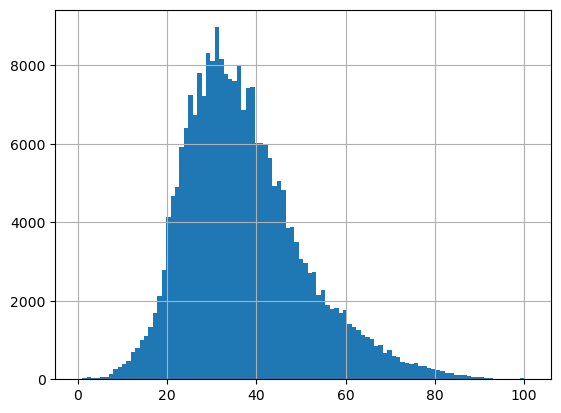

In [11]:
df['age'].hist(bins=102);

In [12]:
df['gender'].value_counts()

M    141038
F    104166
Name: gender, dtype: int64

According to [PickFu.com](https://www.pickfu.com/demographic-segmentation), Marketing demographic age groups are typically: 18-24, 25-34, 35-44, 45-54, 55-64, and 65 and older

We'll split the ages into these groups using .apply and a function.

We're not interested in advertising to individuals under age 18, so we can drop those from our data set.

In [13]:
def age_split(age):
    if age < 18:
        return 'X'
    if age in range(18,25):
        return 'A'
    if age in range(25,35):
        return 'B'
    if age in range(35,45):
        return 'C'
    if age in range(45,55):
        return 'D'
    if age in range(55,65):
        return 'E'
    else:
        return 'F'

In [14]:
df['age'] = df['age'].apply(age_split)

In [15]:
df.head()

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,C,F
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,E,M
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,E,M
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,E,M
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,E,M


In [16]:
df['age'].value_counts()

B    78027
C    65902
D    34742
A    30926
E    16371
F    10792
X     8444
Name: age, dtype: int64

In [17]:
# Dropping indiviudals under 18
df = df.drop(df.loc[df['age'] == 'X'].index)
df = df.reset_index(drop=True)

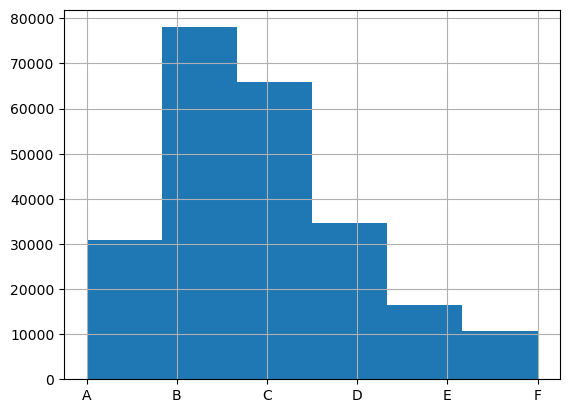

In [18]:
df['age'].sort_values().hist(bins=6);

We have a large class imbalance between our age groups, with group F (65+) having ~11k examples, whereas group B (25-34) has ~80k examples. This could cause problems later on during modeling, where our model could overfit to the Group B and underfit to Group F. Let's proceed as is and determine later on if we must address this, and if so how.

Now that we have our data cleaned and classified, let's split it into file paths and targets.

In [19]:
ohe = OneHotEncoder(sparse=False)
age = ohe.fit_transform(df[['age']]).tolist()
df['age'] = age
df['gender'] = df['gender'].str.get_dummies()['M']
df.head(10)

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
5,fredwillard/nm0929609_rm509975040_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
6,fredwillard/nm0929609_rm924956672_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
7,fredwillard/nm0929609_rm102873088_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
8,fredwillard/nm0929609_rm119650304_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
9,fredwillard/nm0929609_rm3704002560_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1


In [20]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
len(df_train), len(df_test)

(189408, 47352)

Because we will need to use multiple Image Data Generators, we can create a function that will enable these to be created more easily.

In [ ]:
train_test_split()

In [46]:
def ImgGen(dataframe, img_size=(128,128), batch_size=32, brightness=[0.7, 1.3], vsplit=0.2, rrange=15, seed=2023, shuffle=True):
    """Function for the creation of Image Data Generators. 
    
    Parameters
    ----------
    dataframe: dataframe of images to be output by the generators
    img_size: desired output image size; default (128,128)
    batch_size: number of images to be returned by each call to the generator; default 32
    brightness: range of brightness for the images to be augmented by; default [0.7, 1.3]
    vsplit: percentage of images to be allocated to validation set; default 0.2
    rrange: range of rotation for augmented images; default 15
    seed: random seed; default 2023
    shuffle: boolean determining whether to shuffle the images; default True
    """

    dir = os.getcwd() + '\\B3FD\\'

    train_datagen = ImageDataGenerator(validation_split=vsplit, rotation_range=rrange, fill_mode='nearest',
                                       brightness_range=brightness, rescale=1./255)
    
    val_datagen = ImageDataGenerator(validation_split=vsplit, rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(dataframe, dir, x_col='path', y_col=['age', 'gender'], class_mode='multi_output', batch_size=batch_size,
                                                  target_size=img_size, subset='training', shuffle=shuffle, seed=seed)
    
    val_gen = val_datagen.flow_from_dataframe(dataframe, dir, x_col='path', y_col=['age', 'gender'], class_mode='multi_output', batch_size=batch_size,
                                                  target_size=img_size, subset='validation', shuffle=shuffle, seed=seed)
    

    return train_gen, val_gen

We'll also create a function to plot the results of our model training

In [40]:
def plot_history(history):
    train_loss = history.history['loss']
    train_age_loss = history.history['age_loss']
    train_gender_loss = history.history['gender_loss']
    train_age_acc = history.history['age_accuracy']
    train_gender_acc = history.history['gender_accuracy']

    val_loss = history.history['val_loss']
    val_age_loss = history.history['val_age_loss']
    val_gender_loss = history.history['val_gender_loss']
    val_age_acc = history.history['val_age_accuracy']
    val_gender_acc = history.history['val_gender_accuracy']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7.5))

    ax1.set_title('Loss')
    # ax1.set_ylim([0, None])
    sns.lineplot(x=history.epoch, y=train_loss, ax=ax1, label='Training Loss')
    sns.lineplot(x=history.epoch, y=val_loss, ax=ax1, label='Validation Loss')

    ax2.set_title('Loss by Target')
    sns.lineplot(x=history.epoch, y=train_gender_loss, ax=ax2, label='Training Loss: Gender')
    sns.lineplot(x=history.epoch, y=val_gender_loss, ax=ax2, label='Validation Loss: Gender')
    sns.lineplot(x=history.epoch, y=train_age_loss, ax=ax2, label='Training Loss: Age')
    sns.lineplot(x=history.epoch, y=val_age_loss, ax=ax2, label='Validation Loss: Age')


    ax3.set_title('Accuracy')
    ax3.set_ylim([0, None])
    sns.lineplot(x=history.epoch, y=train_gender_acc, ax=ax3, label='Training Accuracy: Gender')
    sns.lineplot(x=history.epoch, y=val_gender_acc, ax=ax3, label='Validation Accuracy: Gender')
    sns.lineplot(x=history.epoch, y=train_age_acc, ax=ax3, label='Training Accuracy: Age')
    sns.lineplot(x=history.epoch, y=val_age_acc, ax=ax3, label='Validation Accuracy: Age')


In [24]:
train_gen, val_gen = ImgGen(df_train, img_size=(64,64))

Found 151527 validated image filenames.
Found 37881 validated image filenames.


In [25]:
# Checking that our train and val generators are working as expected
gen_check = train_gen.filenames + val_gen.filenames
len(gen_check) == len(set(gen_check))

True

Let's also create a test generator to be used later to evaluate our model(s).

In [26]:
test_gen, null_gen = ImgGen(df_test, img_size=(64,64), vsplit=0, brightness=None, rrange=0, shuffle=False)

Found 47352 validated image filenames.
Found 0 validated image filenames.


'Age: 35-44, Gender: Male'

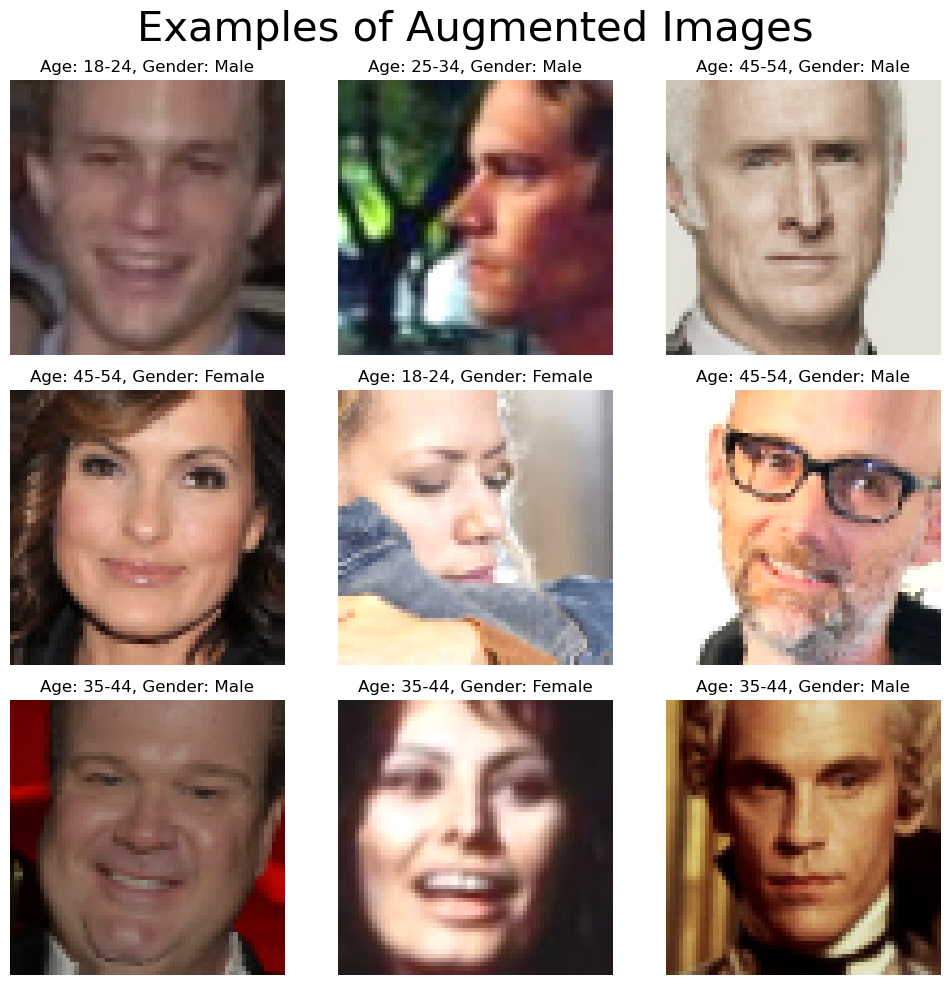

In [78]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# Create list for labeling images
age_groups = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
genders = ['Female', 'Male']
img, label = train_gen.next()
for i, ax in enumerate(axes.flat):
    title = f'Age: {age_groups[label[0][i].argmax()]}, Gender: {genders[label[1][i]]}'
    ax.imshow(img[i])
    ax.set(title=f"{title}")
    ax.axis('off')
fig.suptitle('Examples of Augmented Images', fontsize=30)
plt.tight_layout()
plt.show()
one_image = img[0]

### Model 1

In [28]:
def layer_block(x, filter):
    # copying input x
    x_resid = x

    # conv layer 1
    x = Conv2D(filter, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # conv layer 2
    x = Conv2D(filter, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # creating residual connection
    x_resid = Conv2D(filter, kernel_size=3, strides=(2,2), padding='same')(x_resid)
    x = Add()([x, x_resid])
    x = Activation('relu')(x)

    return x 

In [30]:
def make_model(shape=(64,64,3)):
    filter_size = 128
    
    # first layer and pooling
    input_layer = keras.Input(shape=shape, name='input_layer')
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    # cycle through layer blocks
    for i in range(4):
        if i > 0:
            filter_size *= 2
        x = layer_block(x, filter_size)
    
    # penultimate layer
    x = AveragePooling2D((2,2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    # output layers
    age_output = Dense(6, activation='softmax', name='age')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)

    model = keras.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model


In [31]:
model = make_model()

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3584        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 128)  0           ['batch_normalization[0][0]']

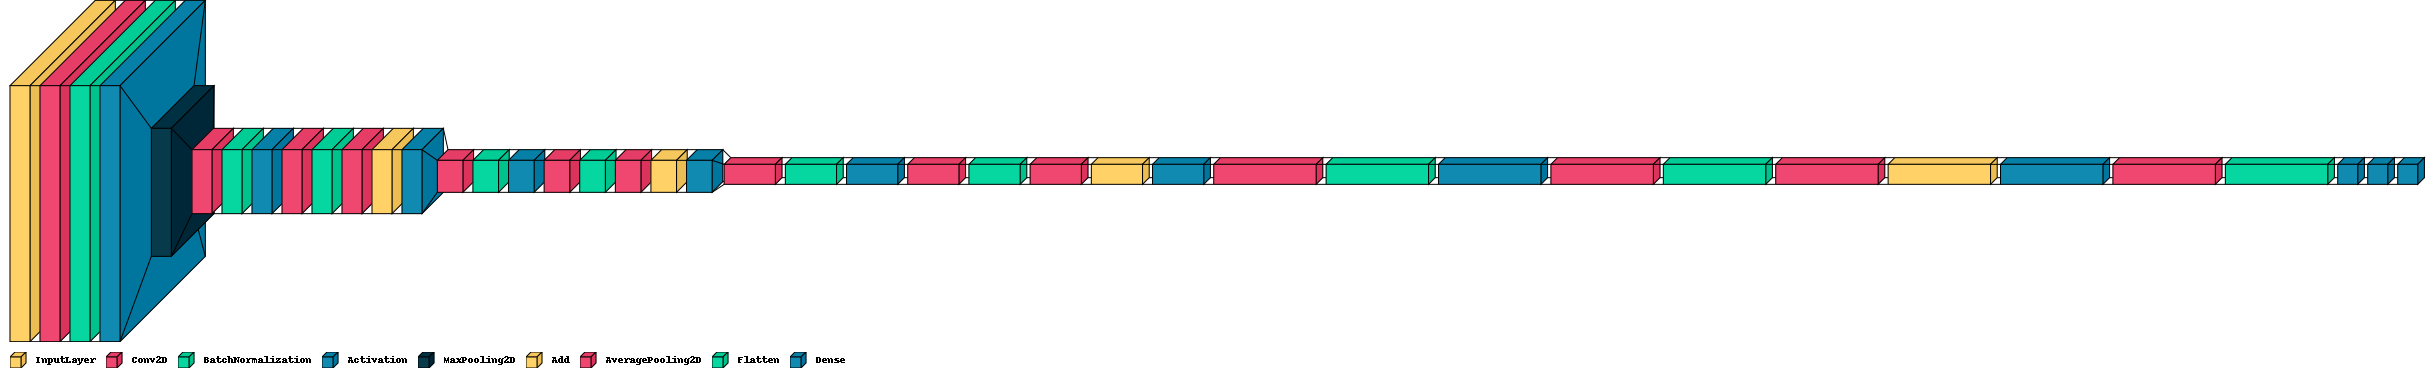

In [36]:
visualkeras.layered_view(model, legend=True)

In [37]:
model.compile(optimizer='adam', loss=[CategoricalCrossentropy(), BinaryCrossentropy()], loss_weights=[50,1], metrics=['accuracy'])

In [400]:
results = model.fit(train_gen, epochs=50, validation_data=val_gen, validation_steps=100//train_gen.batch_size)

Epoch 1/50
4736/4736 [==============================] - 4503s 950ms/step - loss: 72.9302 - age_loss: 1.4472 - gender_loss: 0.5728 - age_accuracy: 0.3776 - gender_accuracy: 0.6971 - val_loss: 70.8872 - val_age_loss: 1.4054 - val_gender_loss: 0.6172 - val_age_accuracy: 0.4062 - val_gender_accuracy: 0.6771
Epoch 2/50
4736/4736 [==============================] - 4497s 950ms/step - loss: 66.1480 - age_loss: 1.3120 - gender_loss: 0.5498 - age_accuracy: 0.4261 - gender_accuracy: 0.7078 - val_loss: 68.9408 - val_age_loss: 1.3682 - val_gender_loss: 0.5286 - val_age_accuracy: 0.4896 - val_gender_accuracy: 0.7292
Epoch 3/50
4736/4736 [==============================] - 4444s 938ms/step - loss: 63.5924 - age_loss: 1.2609 - gender_loss: 0.5460 - age_accuracy: 0.4457 - gender_accuracy: 0.7090 - val_loss: 63.3470 - val_age_loss: 1.2548 - val_gender_loss: 0.6079 - val_age_accuracy: 0.4271 - val_gender_accuracy: 0.6667
Epoch 4/50
4736/4736 [==============================] - 4584s 968ms/step - loss: 61.3

In [407]:
results.history.keys()

dict_keys(['loss', 'age_loss', 'gender_loss', 'age_accuracy', 'gender_accuracy', 'val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_accuracy', 'val_gender_accuracy'])

![Model 1 Results](images/model1results.png)

### Analysis of Model 1 Results
As evidenced by the increasing gap between the Training Age Loss and the Validation Age Loss, our model is greatly overfitting. There are several ways this can be addressed:
- Increase complexity of input data by increasing image size from (64,64) to (128,128)
- Reduce Gender Loss weight. (Currently at 50:1)
- Add Dropout or other forms of regularization

Going forward, we will increase the image size to (128,128), reduce Gender Loss weight to 25, as well as add Dropout.

In [38]:
model.evaluate(test_gen)

1480/1480 [==============================] - 154s 103ms/step - loss: 88.2967 - age_loss: 1.7620 - gender_loss: 0.1959 - age_accuracy: 0.5062 - gender_accuracy: 0.9328


[88.29667663574219,
 1.7620130777359009,
 0.19592343270778656,
 0.5062299370765686,
 0.9328433871269226]

In [446]:
model.save_weights('models/model1_weights')

In [33]:
model.load_weights('models/model1_weights')

In [39]:
model.save('models/model1')

INFO:tensorflow:Assets written to: models/model1\assets


INFO:tensorflow:Assets written to: models/model1\assets


## Model 2

Reworking this model will require modifying the structure of our model definition functions. In particular, adding dropout, as well as altering the shape of input layers. In addition, modifying the dimension of input images will require new image generators. We'll also increase the size of the validation set, in part to decrease training times.

In [48]:
train_gen2, val_gen2 = ImgGen(df_train, vsplit=0.4, batch_size=128)

Found 113645 validated image filenames.
Found 75763 validated image filenames.


In [50]:
test_gen, null_gen = ImgGen(df_test, batch_size=128, vsplit=0, brightness=None, rrange=0, shuffle=False)

Found 47352 validated image filenames.
Found 0 validated image filenames.


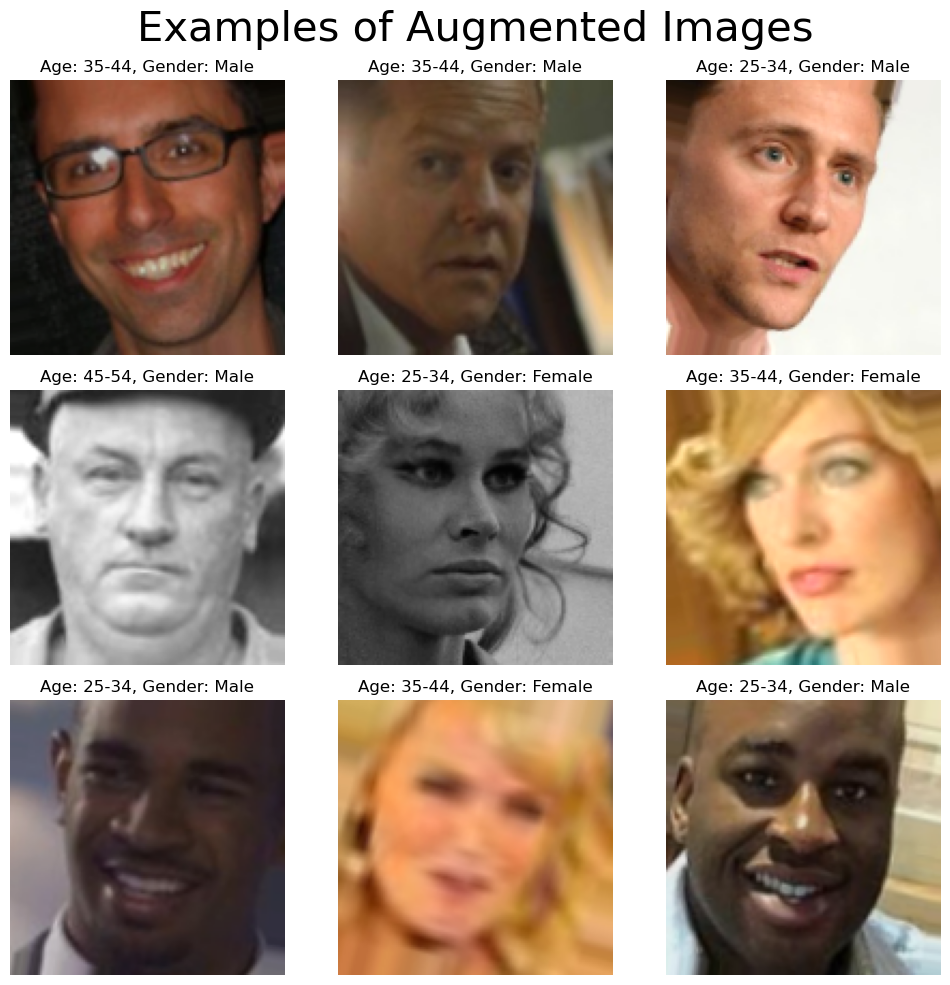

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# Create list for labeling images
age_groups = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
genders = ['Female', 'Male']
img, label = train_gen2.next()
for i, ax in enumerate(axes.flat):
    title = f'Age: {age_groups[label[0][i].argmax()]}, Gender: {genders[label[1][i]]}'
    ax.imshow(img[i])
    ax.set(title=f"{title}")
    ax.axis('off')
fig.suptitle('Examples of Augmented Images', fontsize=30)
plt.tight_layout()
plt.show()
one_image = img[0]

Now let's reinstantiate the model with the aforementioned modifications.

The [original paper proposing dropout](https://arxiv.org/pdf/1207.0580.pdf) only applied it between Dense layers, however [later research](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) has shown some benefit to including a small amount of dropout between convolutional layers as well. Thus we will apply some dropout in both of these instances.

In [52]:
def layer_block(x, filter):
    # copying input x
    x_resid = x

    # conv layer 1
    x = Conv2D(filter, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # conv layer 2
    x = Conv2D(filter, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # creating residual connection
    x_resid = Conv2D(filter, kernel_size=3, strides=(2,2), padding='same')(x_resid)
    x = Add()([x, x_resid])
    x = Activation('relu')(x)

    return x 

In [53]:
def make_model(shape=(128,128,3)):
    filter_size = 128
    
    # first layer and pooling
    input_layer = keras.Input(shape=shape, name='input_layer')
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    # cycle through layer blocks
    for i in range(5):
        if i > 0:
            filter_size *= 2
        x = layer_block(x, filter_size)
    
    # penultimate layer
    x = AveragePooling2D((2,2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # output layers
    age_output = Dense(6, activation='softmax', name='age')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)

    model = keras.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model


In [54]:
model2 = make_model()

In [55]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 12  3584        ['input_layer[0][0]']            
                                8)                                                                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 128, 12  512        ['conv2d_13[0][0]']              
 rmalization)                   8)                                                          

In [56]:
model2.compile(optimizer='adam', loss=[CategoricalCrossentropy(), BinaryCrossentropy()], loss_weights=[25,1], metrics=['accuracy', 'Recall', 'Precision'])

In [81]:
results2 = model2.fit(train_gen2, epochs=20, validation_data=val_gen2, validation_steps=100)

Epoch 1/20
888/888 [==============================] - 7079s 8s/step - loss: 40.4000 - age_loss: 1.5890 - gender_loss: 0.6742 - age_accuracy: 0.3304 - age_recall: 9.6793e-04 - age_precision: 0.4029 - gender_accuracy: 0.5873 - gender_recall_1: 0.9631 - gender_precision_1: 0.5881 - val_loss: 40.2651 - val_age_loss: 1.5832 - val_gender_loss: 0.6863 - val_age_accuracy: 0.3319 - val_age_recall: 3.1250e-04 - val_age_precision: 0.4000 - val_gender_accuracy: 0.5900 - val_gender_recall_1: 0.6113 - val_gender_precision_1: 0.6653
Epoch 2/20
888/888 [==============================] - 6620s 7s/step - loss: 38.6479 - age_loss: 1.5212 - gender_loss: 0.6187 - age_accuracy: 0.3481 - age_recall: 0.0129 - age_precision: 0.4796 - gender_accuracy: 0.6588 - gender_recall_1: 0.8266 - gender_precision_1: 0.6659 - val_loss: 38.2697 - val_age_loss: 1.5066 - val_gender_loss: 0.6040 - val_age_accuracy: 0.3545 - val_age_recall: 2.3437e-04 - val_age_precision: 0.6000 - val_gender_accuracy: 0.6704 - val_gender_recall